# IREN - Competition Libre
## Ships classification with pre-trained network

### Team:
**Jean Fechter** - jean.fecther

**Thibault Boutet** - thibault.boutet

## Imports
Let's import all the necessary modules that we need such as
* The Pre-trainded model
* Optmizer
* Traning callbacks
* Python libraries (Numpy, Sklearn)
*...

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# We define a SEED for the reproductibility of the results
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data loading
Let's load, display and get some informations on the data which are in the kaggle input.

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/navires-2023-libre/ships16x24/ships_16x24_10cat/data",
    labels='inferred',
    label_mode="categorical",
    image_size=(16, 24)
)

Found 35515 files belonging to 10 classes.


In [6]:
# Get the class labels from the dataset
class_labels = dataset.class_names
print(f"Number of classes: {len(class_labels)}")
print(class_labels)

Number of classes: 10
['coastguard_scaled', 'containership_scaled', 'corvette_scaled', 'cruiser_scaled', 'cv_scaled', 'destroyer_scaled', 'methanier_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']


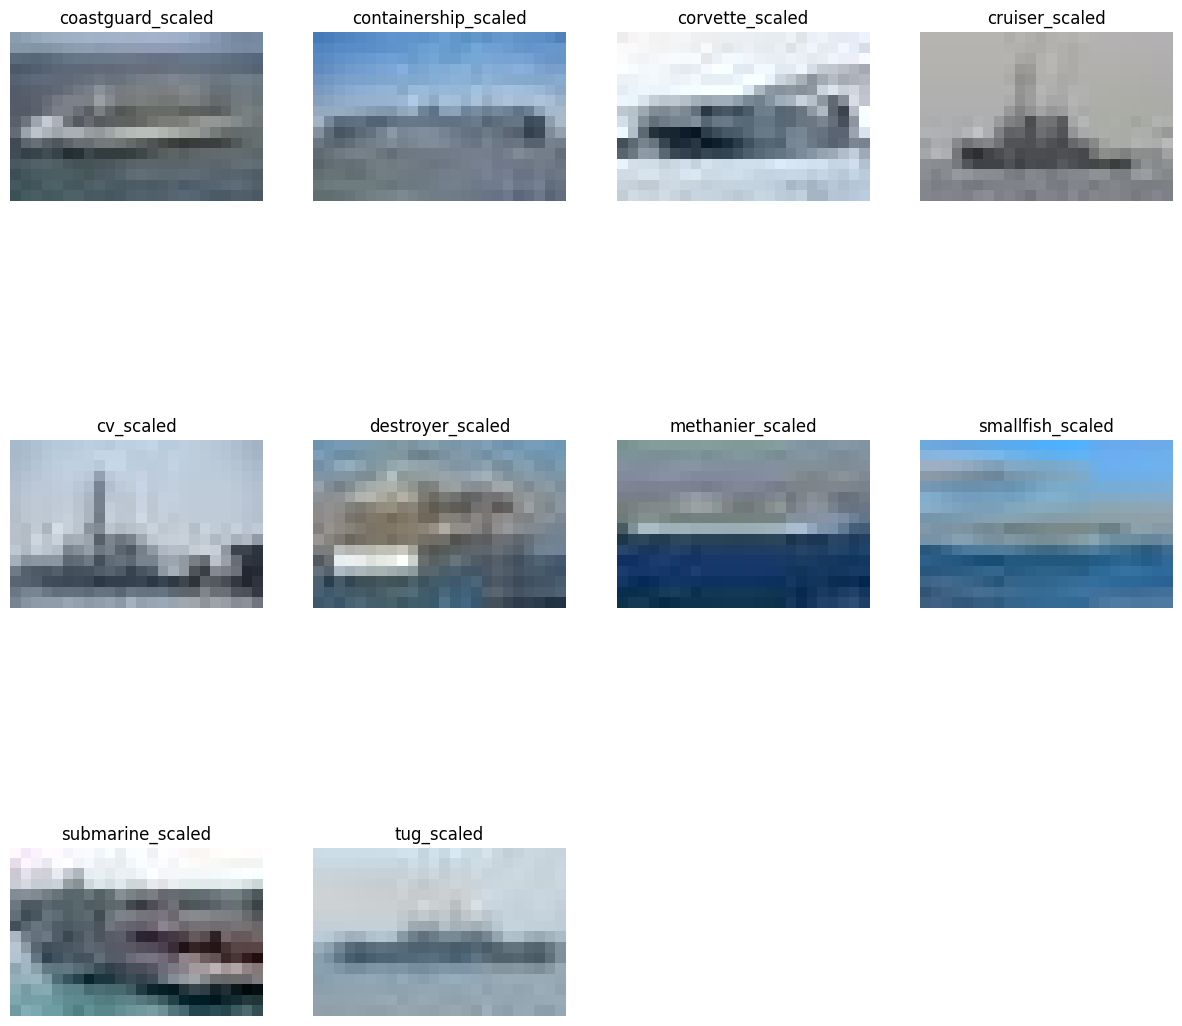

In [7]:
# Display the first image for each class
plt.figure(figsize=(15, 15))
for images, labels in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[i])
        plt.axis("off")

## Data pre-processing
### Resizing
We can notice that the images have a very small size (16x24). To scale the images from their original size of 16x24 to a larger size of 160x240 before passing them to a pre-trained model, we have chosen to apply a 10x ratio. This resizing process will utilize **bicubic** interpolation, which helps to achieve better image scaling results.
### Data augmentation
Data augmentation is a technique that expands a training dataset by applying transformations like rotations, translations, and flipping to the existing data. It improves model generalization and robustness by exposing it to a wider range of variations. This reduces overfitting and enhances pattern recognition by the model.

After testing different configuration of data augmentation, we have chosen to apply:
* Rescaling
* Horizontal flip
* Vertical flip

The other data augmentation techniques such as rotations or translations increase a lot the training time (since these operations are done on CPU) for unsignificative resulsts.
### Train/Validation split
We will split the dataset into **two sets**:
* Train set (**80%** of the dataset): Part of the dataset used to train the model
* Validation set (**20%** of the dataset): Part of the dataset used to test the model's accuracy during the training

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.20,
)

train_set = datagen.flow_from_directory(
    '/kaggle/input/navires-2023-libre/ships16x24/ships_16x24_10cat/data',
    target_size=(160, 240),
    interpolation="bicubic",
    batch_size=32,
    class_mode='categorical',
    seed=SEED,
    subset='training',
)

val_set = datagen.flow_from_directory(
    '/kaggle/input/navires-2023-libre/ships16x24/ships_16x24_10cat/data',
    target_size=(160, 240),
    interpolation="bicubic",
    batch_size=32,
    class_mode='categorical',
    seed=SEED,
    subset='validation',
)

Found 28417 images belonging to 10 classes.
Found 7098 images belonging to 10 classes.


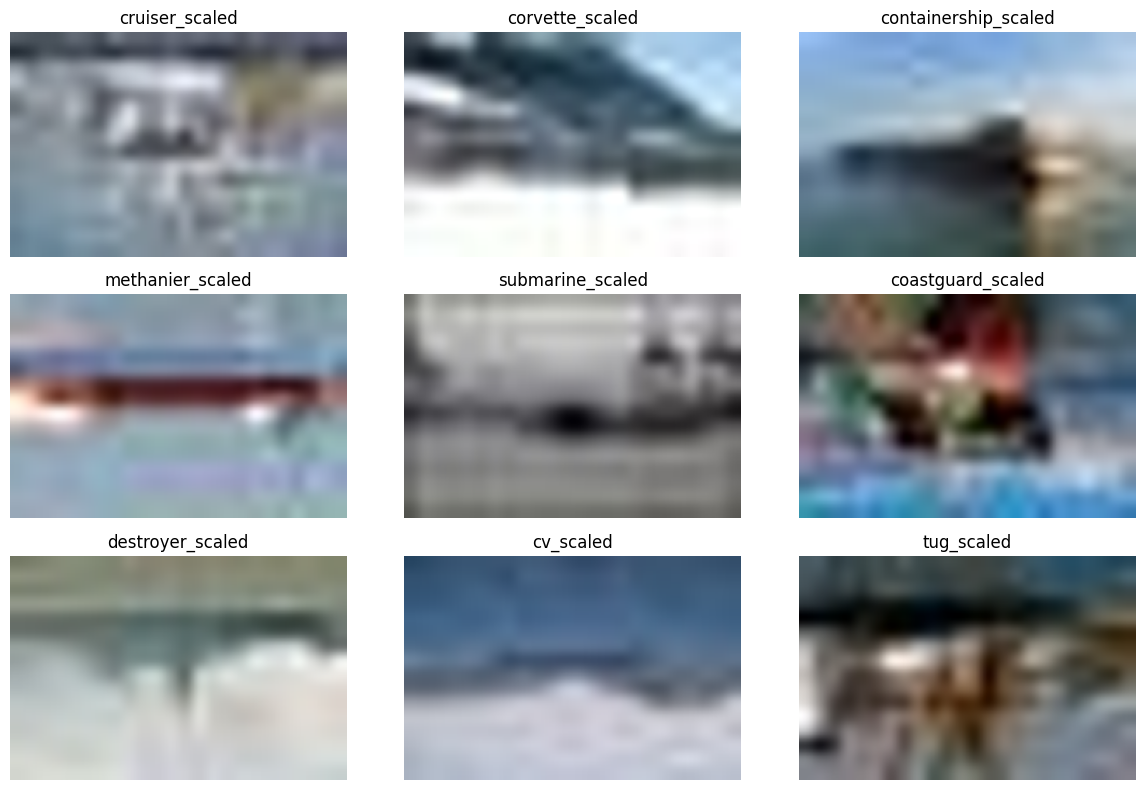

In [9]:
# Display some augmented data
images, labels = train_set.next()
class_labels = train_set.class_indices
class_names = list(class_labels.keys())
display_images = {}

for i in range(len(images)):
    class_index = np.argmax(labels[i])
    class_label = class_names[class_index]
    if class_label not in display_images:
        display_images[class_label] = images[i]

num_rows = 3
num_cols = int(np.ceil(len(display_images) / num_rows))
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))
axes = axes.flatten()

for i, (class_label, image) in enumerate(display_images.items()):
    ax = axes[i]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'{class_label}')
if len(display_images) < len(axes):
    for j in range(len(display_images), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Pre-trained model training
### InceptionResNetV2
For the scope of the problem, we have chosen to use the **InceptionResNetV2** network. 

This choice has been made after testing other networks such as:
* ResNet50
* InceptionV3
* VGG16
* EfficientNetB0

After multiple testing of other networks it appears that InceptionResNetV2 produces great results with an acceptable training time.

Here is the architecture of the InceptionResNetV2 network provided by **Google**:
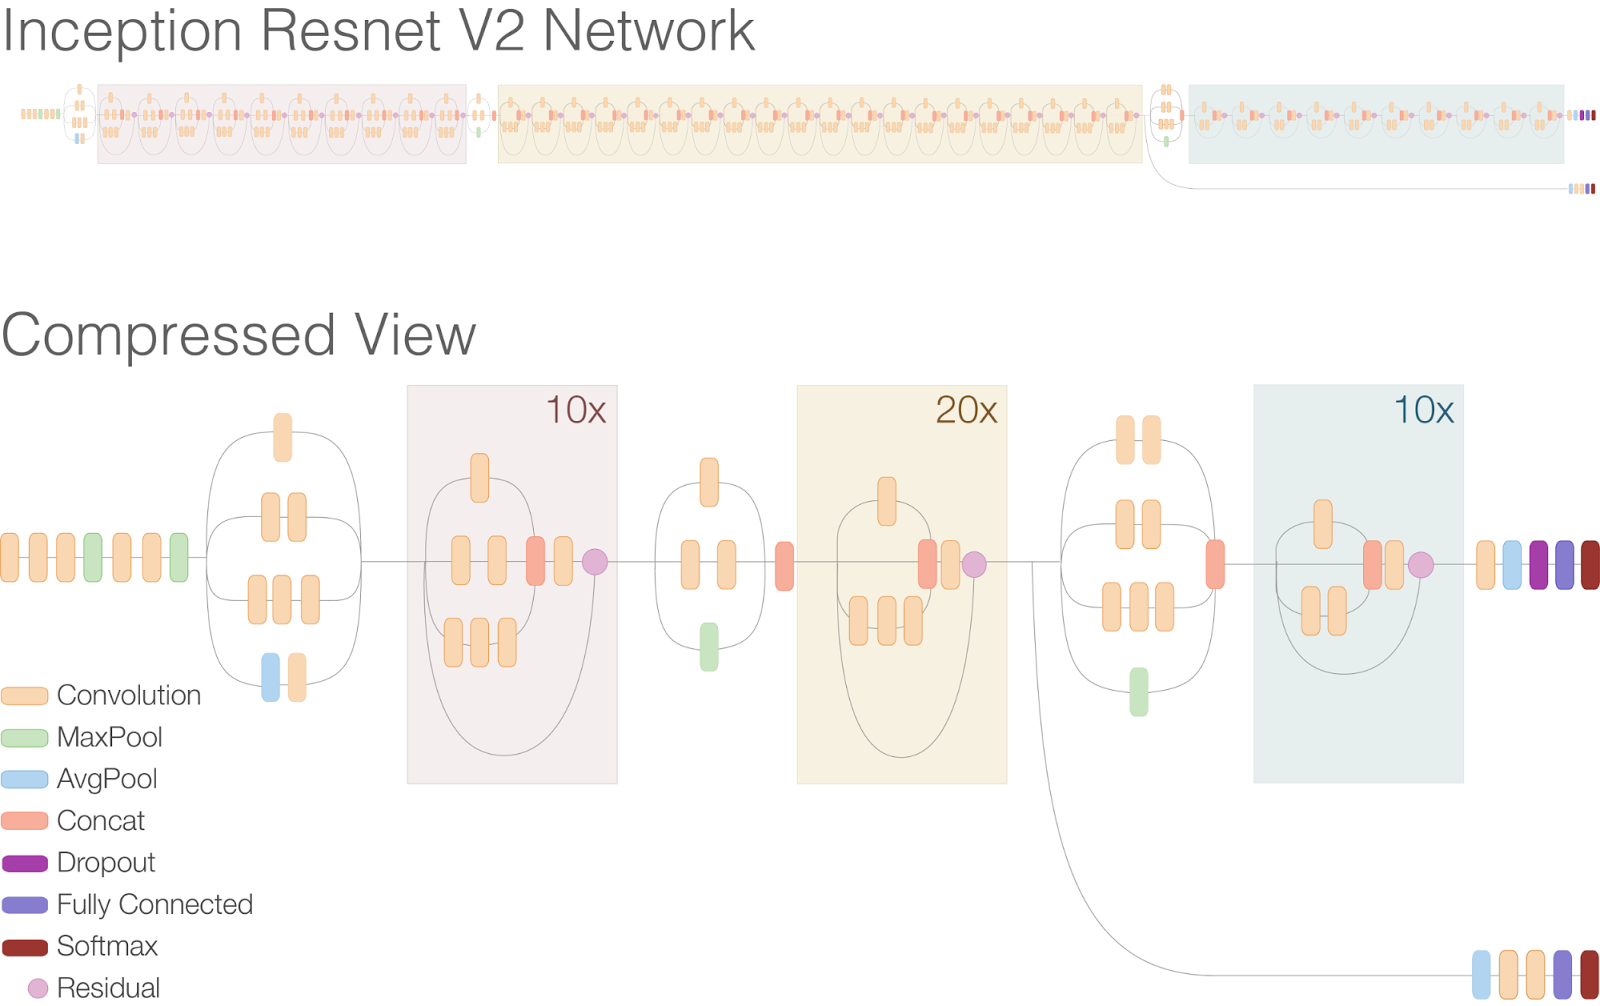

We will load this model with '**imagenet**' weights which are pre-trainded.

In [10]:
# Create the base pre-trained model and load the 'imagenet' weights
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

219055592/219055592 [==============================] - 1s 0us/step


### Adaptation to the problem
Even though we have loaded pre-trainded weights, we need to train the network on our dataset in order to make accurate predictions.

For that, we need to add final layers to the network, which are:
* **GlobalAveragePooling2D**: This layer is used to flatten 2D arrays by computing their averages
* **Dense** (with 1024 neurons and 'relu' as activation function): This layer is used to map the high-level features extracted by the previous layer of the network into a lower-dimensional representation. 
* **Dense** (with 10 neurons and 'softmax' as activation function): This final layer is used to produce the final classification for the 10 ship classes

In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

### Model creation

In [17]:
model = Model(inputs=base_model.input, outputs=predictions)
print("Number of layers : ", len(model.layers))

Number of layers :  783


### Model training
We now to train our model of few epochs in order to adapt it to our classification problem.
To improve and accelerate the convergence of the model, we will use an **optimizer** and **callbacks**.
### Optimizer
We use SGD (Stochastic Gradient Descent) as optimizer. After testing other optimizers (adam, adagrad, ...), it appears that SGD provides the best and the fastest convergence.
We have tuned the optmizer with some parameters:
* **Learning rate**: Initially setted to 0.001
* **Momentum**: This parameters determines the contribution of the previously computed gradients. We set it to 0.9
* **Nesterov**: This parameter when setted to True, takes into account an estimate of the future gradient to compute the current position

### Callbacks
A callback is a function that performs tasks during the training of a model. We will use an **EarlyStopping** callback and an **ReduceLrOnPlateau** callback.
* **EarlyStopping**: This callback allows to stop the training of the model when the loss or the accuracy does not improve after a certain number of epoch. We have chosen to stop the training when the loss does not improve during 3 consecutive epochs
* **RecudeLrOnPlateau**: This callback is used to adjust dynamically the learning rate during the training. We have chosen to wait 1 epoch of no improvment to recude the learning rate by a 0.1 factor. Note that the learning rate can't be smaller than 1e-5

In [18]:
optim = SGD(lr=0.001, momentum=0.9, nesterov=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='auto',restore_best_weights=True)
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.00001, cooldown=2, verbose=1)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Since we use a pre-trained model, we need around 8 epochs to get satisfying results.
nb_epochs = 8
history = model.fit(train_set, batch_size=32, epochs=nb_epochs, validation_data=val_set, callbacks = [early_stopping, lr_callback])

889/889 [==============================] - 268s 301ms/step - loss: 1.0111 - accuracy: 0.6498 - val_loss: 1.0014 - val_accuracy: 0.6619 - lr: 0.0100


## Results analysis
### Score
Let's mesure the model accuarcy, for this we will compute the score for the loss and the accuracy.

In [ ]:
score = model.evaluate(val_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Curves
Once the training is finished, we want to plot the **loss** and the **accuracy** on the training and validation sets.
These two indicators measure the performance of the model.
Here are the formula to compute these indicators:
* Accuracy = Number of correct predictions / Total number of predictions
* Loss (Cross-Entropy Loss) = -Σ(y_actual * log(y_pred))

In [ ]:
# Loss
plt.plot(history.history['loss'], label=['Train'])
plt.plot(history.history['val_loss'], label=['Validation'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label=['Train'])
plt.plot(history.history['val_accuracy'], label=['Validation'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Analysis**:
We can see that both the loss and the accuracy increase quickly until the 2nd epoch for both the training and the validation sets.
Then, the accuracies and the losses continue to increase in a slower way. We can also notice that, except for the first epoch, the model has a better accuracy and loss on the training set than the validation set.

**Meaning**:
The meaning of theses curves is that the model has learned quickly and accurately the training set more than the validation set. At the end of the training, the model has more than **85%** of accuracy on the training data while it has nearly **75%** in the validation data.

We can conclude that the model **does not overfit** the training data since the validation accuracy continue to increase. Furthermore, we can note that the validation accuracy is satisfying.

### Confusion matrix
A confusion matrix is a table that evaluates a classification model's performance by comparing predicted and actual values for each class. It provides key metrics like accuracy, precision, and recall, helping to assess the model's strengths and weaknesses in classifying different categories.

In order to build a confusion matrix, we need to have a set to make a prediction on with our model. Let's take the validation set to do the prediction and construct the matrix.

In [ ]:
Y_pred = model.predict(val_set)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cm = confusion_matrix(val_set.classes, y_pred)

plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

We can notice thanks to the matrix, that the model provides clear classifications for the classes 'cruiser_scaled' and 'destroyer_scaled'.
For some classes, the model struggle to identify certain classes such as 'corvette_scaled' and 'submarine_scaled'. For those classes, the model does not predict in the majority the right class. The model is confused on those classes, to avoid this effect, we will need more or better data as input of your model.

Let's display additional information on the model's predictions:

In [ ]:
print('Classification Report')
print(classification_report(val_set.classes, y_pred))

## Submission
This part is responsible of the loading and prediction of the given test data by the network.

At the end, a *.csv* file is generated with the network's predictions.

In [ ]:
X_test = np.load('/kaggle/input/navires-2023-libre/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

In [ ]:
# Resize the test data in the same size of the training and validation sets
X_test_resized = tf.image.resize(X_test, (160, 240),  method=tf.image.ResizeMethod.BICUBIC).numpy() 

In [ ]:
res = model.predict(X_test_resized).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

In [ ]:
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

## Conclusion
In this notebook, we have used a pre-trained model to classify ships into 10 classes.

At the begining, we have tried to use the model directly without data pre-processing and it appeared quickly that this was a poor approach.

We have itterated a lot to get a complete pipeline with data loading, pre-processing, model creation, model tuning and result analysis. With this pipeline, we are capable to recognize ships with more than **84%** on the given test data.


When we are writing this, we are currently **3rd** in the leaderboard of the competition "libre".